####1 - Install the imdb-sqlite package for python, which downloads movie data files from the IMDb website available in [https://www.imdb.com/interfaces/](https://www.imdb.com/interfaces/), and converts them to a SQLite3 database file.

In [ ]:
#Command to install Python package from Jupyter Notebook:
!pip install imdb-sqlite

####2 - Download the movie data files from the IMDb website and create the SQLite3 database file.

In [ ]:
#Command to obtain the movies data base from IMDb:
!imdb-sqlite --cache-dir "./Data_Movies/" --db "./imdb.db"

####3 - Import the necessary modules to execute the operations.

In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import sqlite3
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

####4 - Define the values for the parameter ​​considered in data analysis operations.

In [ ]:
base_path = './'
data_base_file = base_path + "imdb.db"
output_path = base_path + "Results/"
present_database_information = True #True to create file with database information.
min_perc_common_mov_cat = 5.0 #Values > 0 reduce the number of movies in chart, grouping the others ones in the category others.
min_perc_movies_genres = 0.0 #Values > 0 reduce the number of movies in chart, grouping the others ones in the category others.
min_year_premier = 1500
max_year_premier = 2025
max_genres = None #Values != None and > 0 reduce the number of movies in chart, grouping the others ones in the genre others.
top_best_worst_movies = 10 #Number of movies to be considered in the analysis on the best and worst ones in the set.
min_votes_best_worst_movies = 30000 #Minimum number of ratings/votes required to identify the best and worst movies according to its rating.

####5- Function to create connection to the SQLite3 database file produced with imdb-sqlite package.

In [ ]:
def connection_to_database(db_file="./imdb.db"):
    conn = None
    #Connect to the database if the database file exists, otherwise, the function returns None.
    if os.path.exists(db_file):
        conn = sqlite3.connect(db_file)
    return conn

####6 - Function to create a text file in the output path defined in step 4, with the database information.

In [ ]:
def describe_database(connection=None, output_path=None):
    if not (connection is None):
        #Collect in the database the information to be presented.
        query = "SELECT name AS 'Table_Name' FROM sqlite_master WHERE type = 'table'"
        tables = pd.read_sql_query(query, connection)
        tables = tables["Table_Name"].values.tolist()
        
        #Prepare the information of each table in the database.
        text = "Database Information:\n\n"
        text += "Tables: " + str(tables) + "\n\n"
        
        for table in tables:
            query = "PRAGMA TABLE_INFO(" + table + ")"
            query = pd.read_sql_query(query, connection)
            text += "Schema of table " + table + ":\n"
            text += query.to_string() + "\n"
            text += "*" * 80 + "\n"
        
        #Create the text file with the database information.
        output_file = output_path + 'Data_Base_Information.txt'
        output_file = open(output_file, 'w')
        output_file.write(text)
        output_file.close()

####7 - Function to produce a pie chart to present the percentage of movies in the database according to their category.

In [ ]:
def plot_most_common_movies_by_categories(connection=None, min_percent_common=5.0, output_path=None):
    if not (connection is None):
        query = "SELECT type, COUNT(*) AS Total FROM titles GROUP BY type"
        query = pd.read_sql_query(query, connection)
        query['Percent'] = (np.array(query['Total']) / query['Total'].sum()) * 100.0

        #Verify the minimum percentage to be considered in the chart.
        if min_percent_common > 0.0:
            #Join the categories with total movies equivalent to a percentage lower than that required (min_percent_common).
            others = list(query[query['Percent'] < min_percent_common]['Total'])
            if len(others) > 0:
                others = {
                    'type': 'others',
                    'Total': query[query['Percent'] < min_percent_common]['Total'].sum(),
                    'Percent': query[query['Percent'] < min_percent_common]['Percent'].sum(),
                }
                query = query[query['Percent'] >= min_percent_common]
                query = query.append(others, ignore_index=True)
        
        #Sort the categories to be displayed in descending order according the the percentage of movies.
        query = query.sort_values(by='Total', ascending=False)
        query.index = range(len(query))
        
        #Produce the legend of the chart.
        labels = []
        for i in query.index:
            label = str(query['type'][i]) + " [" + str(round(query['Percent'][i], 2)) + "%]"
            labels.append(label)
        plt.figure()
        #Produce the pie chart with radius equivalent to the amount of categories.
        plt.pie(query['Total'], radius=len(query['Total'])/2)
        plt.legend(labels, loc=0, fontsize=12)
        plt.title("Distribution of Titles by Categories", loc='Center', fontsize=16, pad=len(query['Total'])*20)
        #Save the chart in the defined output path.
        plt.savefig(output_path + "Plot_Most_Common_Movies_by_Categories.png", bbox_inches='tight')

####8 - Function to produce a bar chart to display the percentage of movies related to each genre.

In [ ]:
def plot_percent_movies_by_genres(connection=None, min_percent=0.0, output_path=None):
    if not (connection is None):
        query = "SELECT genres, COUNT(*) AS Total FROM titles WHERE type = 'movie' GROUP BY genres"
        query = pd.read_sql_query(query, connection)
        #Convert the words in values for genre to lower case.
        query['genres'] = query['genres'].str.lower().values
        #Remove records with null value in any column from the database.
        query = query.dropna()

        #Prepare the chart if there are records without null values ​​in the database.
        if len(query) > 0:
            #Identify the genres in the database, considering that more than one genre might have been related to some movies.
            token_pattern = '\\b[\\w-]+\\b'
            #Produce a binary matrix to identify and count the genres associated to each movie.
            vectorizer = CountVectorizer(token_pattern=token_pattern)
            temp_query = vectorizer.fit_transform(query['genres'])
            #List the individual genres identified in the database.
            unique_genres = list(vectorizer.get_feature_names())
            temp_query = pd.DataFrame(temp_query.todense(), columns=unique_genres)
            
            #Calculate the percentual of movies associated to each identified genre
            #according to the matrix produced in the previous action.
            totals = []
            for c in unique_genres:
                value = np.where(np.array(temp_query[c]) > 0)[0]
                value = np.sum(np.array(query['Total'])[value])
                totals.append(value)
            totals = np.array(totals)
            percents = (totals / np.sum(totals)) * 100.0

            #Create a pandas DataFrame with information to be considered in the chart.
            temp_query = np.array([unique_genres, totals, percents]).T
            temp_query = pd.DataFrame(temp_query, columns=['genres', 'Total', 'Percent'])
            #Change the data type of numerical columns from string to the respective numerical type.
            temp_query['Total'] = np.array(temp_query['Total']).astype(int)
            temp_query['Percent'] = np.array(temp_query['Percent']).astype(float)

            #Verify the minimum percentage to be considered in the chart.
            if min_percent > 0.0:
                #Join the genres with total movies equivalent to a percentage lower than that required (min_percent).
                others = list(temp_query[temp_query['Percent'] < min_percent]['Total'])
                if len(others) > 0:
                    others = {
                        'genres': 'others',
                        'Total': temp_query[temp_query['Percent'] < min_percent]['Total'].sum(),
                        'Percent': temp_query[temp_query['Percent'] < min_percent]['Percent'].sum(),
                    }
                    temp_query = temp_query[temp_query['Percent'] >= min_percent]
                    temp_query = temp_query.append(others, ignore_index=True)
            
            #Sort the genres to be displayed in descending order according the the percentage of movies.
            temp_query = temp_query.sort_values(by='Percent', ascending=False)
            temp_query.index = range(len(temp_query))
            
            width = len(temp_query['genres'])/2 if len(temp_query['genres'])/2 > 8 else 8
            height = len(temp_query['genres'])/4 if len(temp_query['genres'])/4 > 6 else 6
            plt.figure(figsize=(width, height))
            #Produce the horizontal bar chart with the percentage of movies associated to each genre.
            sns.barplot(x=temp_query['Percent'], y=temp_query['genres'], orient="h")
            #Include textual information with the total and percentage of movies associated to each genre.
            for i in temp_query.index:
                text = str(temp_query['Total'][i]) + ' [' + str(round(temp_query['Percent'][i], 1)) + '%]'
                plt.text(np.max(temp_query['Percent'])/2, i+0.25, text)
            plt.xlabel("Total of Movies (%)", fontsize=14)
            plt.ylabel('Movie Genre', fontsize=14)
            plt.title('Distribution of Movies by Genres', fontsize=16)
            #Save the chart in the defined output path.
            plt.savefig(output_path + 'Plot_Percent_Movies_by_Genres.png', bbox_inches='tight')

####9 - Function to produce a bar chart with the median evaluation/rating assigned by users to each movie genre.

In [ ]:
def plot_median_evaluation_movies_by_genres(connection=None, min_year_premier=1500, max_year_premier=2025, max_genres=None, output_path=None):
    if not (connection is None):
        query = "SELECT genres, rating FROM " \
                + "titles JOIN ratings ON ratings.title_id = titles.title_id " \
                + "WHERE titles.type = 'movie' AND titles.premiered >= " + str(min_year_premier) + " AND titles.premiered <= " + str(max_year_premier)
        query = pd.read_sql_query(query, connection)
        #Convert the words in values for genre to lower case.
        query['genres'] = query['genres'].str.lower().values
        #Remove records with null value in any column from the database.
        query = query.dropna()
        
        #Prepare the chart if there are records without null values ​​in the database.
        if len(query) > 0:
            #Identify the genres in the database, considering that more than one genre might have been related to some movies.
            token_pattern = '\\b[\\w-]+\\b'
            #Produce a binary matrix to identify and count the genres associated to each movie.
            vectorizer = CountVectorizer(token_pattern=token_pattern)
            temp_query = vectorizer.fit_transform(query['genres'])
            #List the individual genres identified in the database.
            unique_genres = vectorizer.get_feature_names()
            temp_query = pd.DataFrame(temp_query.todense(), columns=unique_genres)

            #Calculate the median of the evaluation of movies associated to each identified genre
            #according to the matrix produced in the previous action.
            medians = []
            for c in unique_genres:
                value = np.where(np.array(temp_query[c]) > 0)[0]
                value = np.median(np.array(query['rating'])[value])
                medians.append(value)
            medians = np.array(medians)

            #Create a pandas DataFrame with information to be considered in the chart.
            temp_query = np.array([unique_genres, medians]).T
            temp_query = pd.DataFrame(temp_query, columns=['genres', 'Median'])
            #Change the datatype of numerical columns from string to the respective numerical type.
            temp_query['Median'] = np.array(temp_query['Median']).astype(float)
            del medians
            
            #Sort the genres to be displayed in descending order according the the median of evaluation.
            temp_query = temp_query.sort_values(by='Median', ascending=False)
            temp_query.index = range(len(temp_query))

            #Verify the maximum number of genre to be considered in the chart.
            if not (max_genres is None):
                if max_genres < len(temp_query):
                    #Join the genres with the lowest medians to keep just the specified number of genres (max_genres).
                    others = {
                        'genres': 'others',
                        'Median': np.median(np.array(temp_query['Median'][max_genres:len(temp_query)]))
                    }
                    temp_query = temp_query[:][0:max_genres]
                    temp_query = temp_query.append(others, ignore_index=True)

            #Collect information in the database to be included in the chart as text.
            query = "SELECT genres, COUNT(*) AS Total FROM titles WHERE type = 'movie' GROUP BY genres"
            query = pd.read_sql_query(query, connection)
            query['genres'] = query['genres'].str.lower().values
            #Remove the records from the database with null value in any column.
            query = query.dropna()
            query.index = range(len(query))

            #Identify the genres in the database, considering that more than one genre might have been related to some movies.
            token_pattern = '\\b[\\w-]+\\b'
            vectorizer = CountVectorizer(token_pattern=token_pattern)
            temp_query_2 = vectorizer.fit_transform(query['genres'])
            unique_genres = list(vectorizer.get_feature_names())
            temp_query_2 = pd.DataFrame(temp_query_2.todense(), columns=unique_genres)

            #Join the genres with the lowest medians to keep just the specified number of genres.
            others = {}
            if not (max_genres is None):
                if max_genres < len(temp_query_2):
                    indices = []
                    for c in temp_query['genres']:
                        if c != 'others':
                            value = np.where(np.array(temp_query_2[c]) > 0)[0]
                            indices.extend(list(value))
                    indices = list(np.unique(indices))
                    indices = list(np.delete(range(len(query)), indices))
                    others = {
                        'genres': 'others',
                        'Total': np.sum(query['Total'][indices]),
                    }

            #Calculate the total of movies associated to each genre to be presented in the chart as text.
            totals = []
            for c in temp_query['genres']:
                if c != 'others':
                    value = np.where(np.array(temp_query_2[c]) > 0)[0]
                    value = np.sum(np.array(query['Total'])[value])
                    totals.append(value)
            if len(others.keys()) > 0:
                totals.append(others['Total'])

            temp_query_2 = {
                'genres': list(temp_query['genres']),
                'Total': totals,
            }
            del totals
            temp_query_2 = pd.DataFrame(temp_query_2)
            temp_query_2.index = range(len(temp_query_2))

            width = len(temp_query['genres'])/2 if len(temp_query['genres'])/2 > 8 else 8
            height = len(temp_query['genres'])/4 if len(temp_query['genres'])/4 > 6 else 6
            plt.figure(figsize=(width, height))
            #Produce the horizontal bar chart with the median of evaluation of the movies of each genre.
            sns.barplot(x=temp_query['Median'], y=temp_query['genres'], orient="h")
            #Include textual information with the total of movies associated to each genre.
            for i in temp_query_2.index:
                plt.text(np.max(temp_query['Median'])/2, i+0.25, str(temp_query_2['Total'][i]))
                plt.text(temp_query['Median'][i], i+0.25, str(round(temp_query['Median'][i], 2)))
            plt.xlabel("Median of Evaluation Rating", fontsize=14)
            plt.ylabel('Movie Genre', fontsize=14)
            plt.title('Evaluation Rating of Movies by Genres', fontsize=16)
            #Save the chart in the defined output path.
            plt.savefig(output_path + 'Plot_Median_Evaluation_Rating_Movies_by_Genres.png', bbox_inches='tight')

####10 - Function to produce a graph with the variation of the median evaluation of movies according to the premier year.

In [ ]:
def plot_median_evaluation_movies_by_premier_year(connection=None, min_year_premier=1500, max_year_premier=2025, output_path=None):
    if not (connection is None):
        query = "SELECT premiered, rating FROM titles " \
                + "JOIN ratings ON ratings.title_id = titles.title_id " \
                + "WHERE titles.type = 'movie' AND " \
                + "titles.premiered >= " + str(min_year_premier) + " AND titles.premiered <= " + str(max_year_premier) \
                + " ORDER BY premiered ASC"
        query = pd.read_sql_query(query, connection)
        #Remove the records with null value in any column.
        query = query.dropna()

        #Prepare the data for the chart if there are records without null values ​​in the database.
        if len(query) > 0:
            #Calculate the median evaluation of movies premiered in each identified in the database.
            medians = []
            for y in np.unique(query['premiered']):
                value = np.where(np.array(query['premiered']) == y)[0]
                value = np.median(np.array(query['rating'])[value])
                medians.append(value)
            
            width = 8
            height = 6
            plt.figure(figsize=(width, height))
            #Plot the variation of the median of evaluation of the movies according to their premier year.
            plt.plot(np.unique(query['premiered']), medians)
            plt.xlabel('Year', fontsize=14)
            plt.ylabel('Median of Evaluation Rating', fontsize=14)
            plt.title('Evaluation Rating of Movies in Premiered Years', fontsize=16)
            #Save the chart in the defined output path.
            plt.savefig(output_path + 'Plot_Median_Evaluation_Rating_Movies_in_Years.png', bbox_inches='tight')

####11 - Function to produce a bar chart to illustrate the median duration time of each movie according to its genre.

In [ ]:
def plot_median_duration_movie_by_genres(connection=None, max_genres=None, output_path=None):
    if not (connection is None):
        query = "SELECT runtime_minutes, genres FROM titles " \
                + "WHERE type = 'movie' " \
                + "GROUP BY genres"
        query = pd.read_sql_query(query, connection)
        query['genres'] = query['genres'].str.lower().values
        #Remove records with null value in any column from the database.
        query = query.dropna()

        #Prepare the data for the chart if there are records without null values ​​in the database.
        if len(query) > 0:
            #Identify the genres in the database, considering that more than one genre might have been related to some movies.
            token_pattern = '\\b[\\w-]+\\b'
            #Produce a binary matrix to identify and count the genres associated to each movie.
            vectorizer = CountVectorizer(token_pattern=token_pattern)
            temp_query = vectorizer.fit_transform(query['genres'])
            #List the individual genres identified in the database.
            unique_genres = list(vectorizer.get_feature_names())
            temp_query = pd.DataFrame(temp_query.todense(), columns=unique_genres)
            
            #Calculate the median durantion of the movies according to their genre.
            medians = []
            for c in unique_genres:
                value = np.where(np.array(temp_query[c]) > 0)[0]
                value = np.median(np.array(query['runtime_minutes'])[value])
                medians.append(value)
            
            #Create a pandas DataFrame with information to be considered in the chart.
            temp_query = np.array([unique_genres, medians]).T
            temp_query = pd.DataFrame(temp_query, columns=['genres', 'Median_Runtime'])
            temp_query['Median_Runtime'] = np.round(np.array(temp_query['Median_Runtime']).astype(float)).astype(int)
            del medians

            #Sort the genres to be displayed in descending order according the the median of duration time.
            temp_query = temp_query.sort_values(by='Median_Runtime', ascending=False)
            temp_query.index = range(len(temp_query))
            
            #Verify the maximum number of genre to be considered in the chart.
            if not (max_genres is None):
                if max_genres < len(temp_query):
                    #Join the genres with the lowest medians duration to keep just the specified number of genres (max_genres).
                    others = {
                        'genres': 'others',
                        'Median_Runtime': int(round(np.median(np.array(temp_query['Median_Runtime'][max_genres:len(temp_query)])))),
                    }
                    temp_query = temp_query[:][0:max_genres]
                    temp_query = temp_query.append(others, ignore_index=True)
                    temp_query.index = range(len(temp_query))
            
            width = len(temp_query['genres'])/2 if len(temp_query['genres'])/2 > 8 else 8
            height = len(temp_query['genres'])/4 if len(temp_query['genres'])/4 > 6 else 6
            plt.figure(figsize=(width, height))
            #Produce the horizontal bar chart with the median of duration of movies of each genre.
            sns.barplot(x=temp_query['Median_Runtime'], y=temp_query['genres'], orient="h")
            #Include textual information with the median duration of the movies associated to each genre.
            for i in temp_query.index:
                plt.text(temp_query['Median_Runtime'][i], i+0.25, str(temp_query['Median_Runtime'][i]))
            plt.xlabel('Median of Duration (minutes)', fontsize=14)
            plt.ylabel('Movie Genre', fontsize=14)
            plt.title('Duration of Movies by Genres', fontsize=16)
            #Save the chart in the defined output path.
            plt.savefig(output_path + 'Plot_Median_Runtime_Movies_by_Genres.png', bbox_inches='tight')

####12 - Function to produce a table in a .csv text file with the best movies in the database in the defined output path.

In [ ]:
def table_top_best_movies(connection=None, top=10, min_votes=25000, output_path=None):
    if not (connection is None):
        query = "SELECT primary_title AS Title, rating " \
                + "FROM titles JOIN ratings ON titles.title_id = ratings.title_id " \
                + "WHERE titles.type = 'movie' AND ratings.votes >= " + str(min_votes) \
                + " ORDER BY rating DESC LIMIT " + str(top)
        query = pd.read_sql_query(query, connection)

        query.columns = ['Best Movie Title', 'Rating']
        
        #Save the table in the defined output path.
        query.to_csv(output_path + 'Table_Top_Best_Movies.csv', index=False)

####13 - Function to produce a table in a .csv text file with the worst movies in the database in the defined output path.

In [ ]:
def table_top_worst_movies(connection=None, top=10, min_votes=25000, output_path=None):
    if not (connection is None):
        query = "SELECT primary_title AS Title, rating " \
                + "FROM titles JOIN ratings ON titles.title_id = ratings.title_id " \
                + "WHERE titles.type = 'movie' AND ratings.votes >= " + str(min_votes) \
                + " ORDER BY rating ASC LIMIT " + str(top)
        query = pd.read_sql_query(query, connection)

        query.columns = ['Worst Movie Title', 'Rating']
        
        #Save the table in the defined output path.
        query.to_csv(output_path + 'Table_Top_Worst_Movies.csv', index=False)

####14 - Function to present the content of the text files produced in the analysis operations.

In [ ]:
def present_text_output_files(output_path=None):
    #List the text files of txt format.
    text_files = glob.glob(output_path + '*.txt')
    if len(text_files) > 0:
        #Present the content of each text file of txt format.
        for text_file in text_files:
            print("\n")
            content_file = open(text_file, 'r')
            content_file = content_file.readlines()
            for line in content_file:
                print(line)
    
    #List the text files of csv format.
    text_files = glob.glob(output_path + '*.csv')
    if len(text_files) > 0:
        #Present the content of each file of csv format.
        for text_file in text_files:
            print("\n")
            content_file = pd.read_csv(text_file)
            print(content_file)
    
    print("\n")

####15 - Function to call all analysis operations by the functions implemented above.

In [ ]:
def run_analysis():
    #Connect to the database produced by data movies from IMDb website.
    connection = connection_to_database(db_file=data_base_file)

    #Execute the analysis operations if the database connection has been established.
    if not (connection is None):
        if present_database_information:
            describe_database(connection=connection, output_path=output_path)
        print('plot_most_common_movies_by_categories()...')
        plot_most_common_movies_by_categories(connection=connection, min_percent_common=min_perc_common_mov_cat, output_path=output_path)
        print('plot_percent_movies_by_genres()...')
        plot_percent_movies_by_genres(connection=connection, min_percent=min_perc_movies_genres, output_path=output_path)
        print('plot_median_evaluation_movies_by_genres()...')
        plot_median_evaluation_movies_by_genres(connection=connection, min_year_premier=min_year_premier, max_year_premier=max_year_premier, max_genres=max_genres, output_path=output_path)
        print('plot_median_evaluation_movies_by_premier_year()...')
        plot_median_evaluation_movies_by_premier_year(connection=connection, min_year_premier=min_year_premier, max_year_premier=max_year_premier, output_path=output_path)
        print('plot_median_duration_movie_by_genres()...')
        plot_median_duration_movie_by_genres(connection=connection, max_genres=max_genres, output_path=output_path)
        print('table_top_best_movies()...')
        table_top_best_movies(connection=connection, top=top_best_worst_movies, min_votes=min_votes_best_worst_movies, output_path=output_path)
        print('table_top_worst_movies()...')
        table_top_worst_movies(connection=connection, top=top_best_worst_movies, min_votes=min_votes_best_worst_movies, output_path=output_path)
        print('present_text_output_files()...')
        present_text_output_files(output_path=output_path)

####16 - Execute the function to call all functions related to the analysis operations.

plot_most_common_movies_by_categories()...
plot_percent_movies_by_genres()...


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


plot_median_evaluation_movies_by_genres()...


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


plot_median_evaluation_movies_by_premier_year()...
plot_median_duration_movie_by_genres()...


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


table_top_best_movies()...
table_top_worst_movies()...
present_text_output_files()...


Database Information:



Tables: ['people', 'titles', 'akas', 'crew', 'episodes', 'ratings']



Schema of table people:

   cid       name     type  notnull dflt_value  pk

0    0  person_id  VARCHAR        0       None   1

1    1       name  VARCHAR        0       None   0

2    2       born  INTEGER        0       None   0

3    3       died  INTEGER        0       None   0

********************************************************************************

Schema of table titles:

   cid             name     type  notnull dflt_value  pk

0    0         title_id  VARCHAR        0       None   1

1    1             type  VARCHAR        0       None   0

2    2    primary_title  VARCHAR        0       None   0

3    3   original_title  VARCHAR        0       None   0

4    4         is_adult  INTEGER        0       None   0

5    5        premiered  INTEGER        0       None   0

6    6            

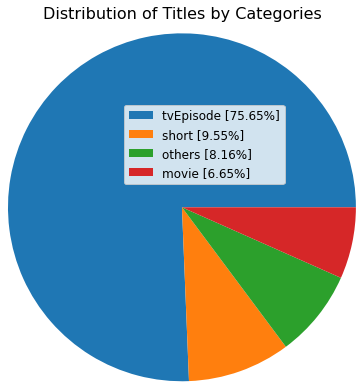

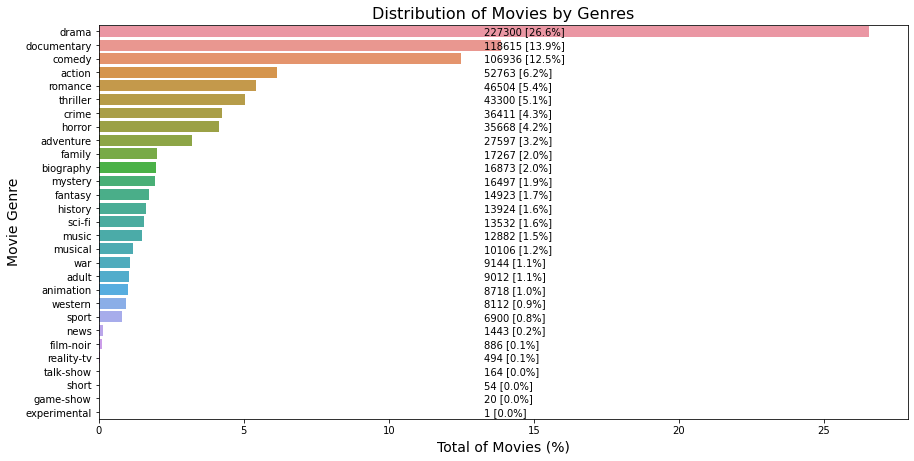

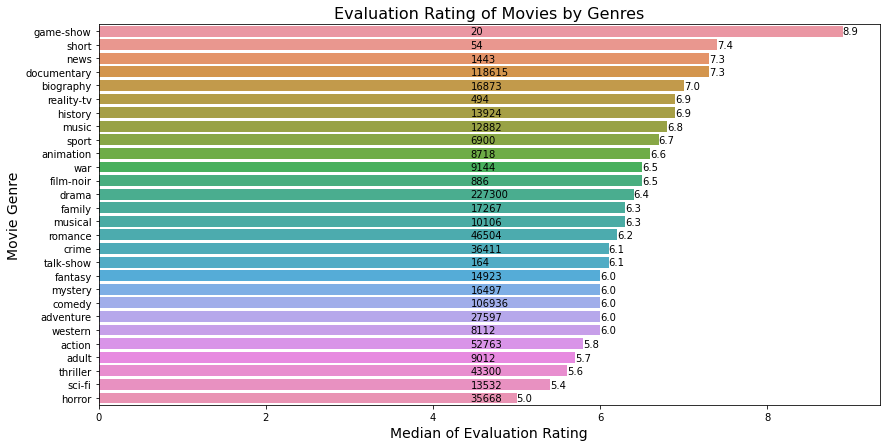

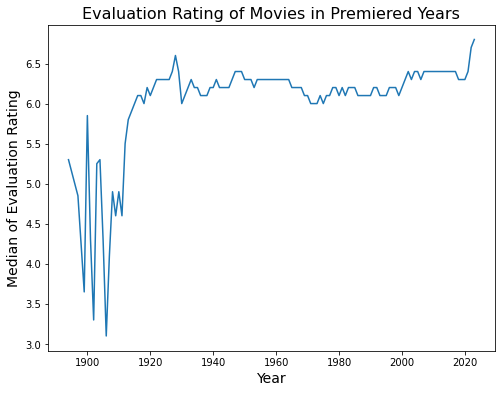

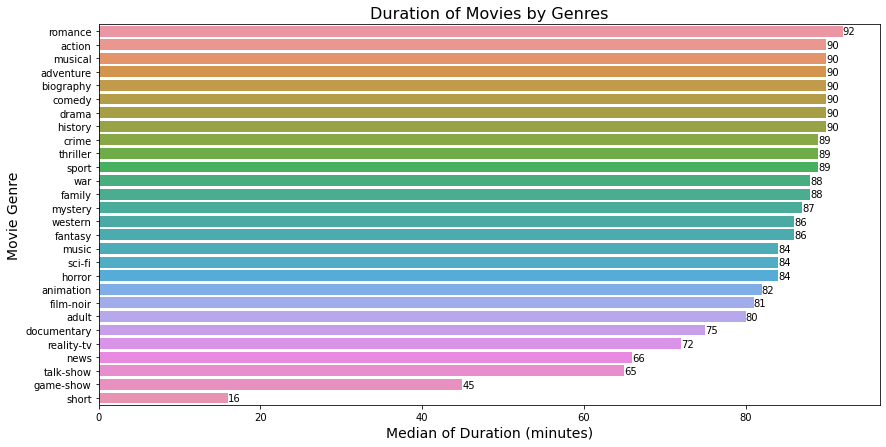

In [ ]:
#Results obtained from data downloaded in December/2022.
run_analysis()